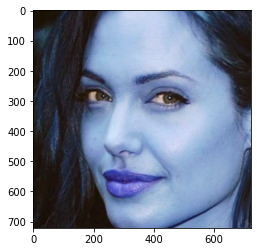

In [6]:
import numpy as np 
import cv2
import matplotlib
from matplotlib import pyplot as plt
#Detect face and eyes
%matplotlib inline
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')  
image_path = []
def image_bundle(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
cropped_image =   image_bundle('./test_images/angelina2.jpg')
plt.imshow(cropped_image)


In [3]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped_image/"

In [2]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

NameError: name 'path_to_data' is not defined

In [4]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)


In [5]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = image_bundle(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1
            

Generating cropped images in folder:  ./dataset/cropped_image/angelina_jollie
Generating cropped images in folder:  ./dataset/cropped_image/chris_evans
Generating cropped images in folder:  ./dataset/cropped_image/ryan_reynolds
Generating cropped images in folder:  ./dataset/cropped_image/scarlet_johansson


In [6]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [7]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'angelina_jollie': 0,
 'chris_evans': 1,
 'ryan_reynolds': 2,
 'scarlet_johansson': 3}

In [8]:
X = []
y = []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [9]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(84, 4096)

Data cleaning is done

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)



NameError: name 'X' is not defined

In [12]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
model_params = {
    'MLPClassifier':{
        'model': MLPClassifier(solver='adam'),
        'params':{
        'mlpclassifier__hidden_layer_sizes': [(10,10), (5,10,15)],
        'mlpclassifier__solver': ['sgd', 'adam'],
        'mlpclassifier__alpha': [0.0001, 0.05],
        }
        
    },
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [13]:
pipeline = make_pipeline( MLPClassifier())
sorted(pipeline.get_params().keys())

['memory',
 'mlpclassifier',
 'mlpclassifier__activation',
 'mlpclassifier__alpha',
 'mlpclassifier__batch_size',
 'mlpclassifier__beta_1',
 'mlpclassifier__beta_2',
 'mlpclassifier__early_stopping',
 'mlpclassifier__epsilon',
 'mlpclassifier__hidden_layer_sizes',
 'mlpclassifier__learning_rate',
 'mlpclassifier__learning_rate_init',
 'mlpclassifier__max_fun',
 'mlpclassifier__max_iter',
 'mlpclassifier__momentum',
 'mlpclassifier__n_iter_no_change',
 'mlpclassifier__nesterovs_momentum',
 'mlpclassifier__power_t',
 'mlpclassifier__random_state',
 'mlpclassifier__shuffle',
 'mlpclassifier__solver',
 'mlpclassifier__tol',
 'mlpclassifier__validation_fraction',
 'mlpclassifier__verbose',
 'mlpclassifier__warm_start',
 'steps',
 'verbose']

In [14]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

D:\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: Conve

,model,best_score,best_params
0,MLPClassifier,0.701282,"{'mlpclassifier__alpha': 0.05, 'mlpclassifier_..."
1,svm,0.747436,"{'svc__C': 1, 'svc__kernel': 'linear'}"
2,random_forest,0.601282,{'randomforestclassifier__n_estimators': 10}
3,logistic_regression,0.778205,{'logisticregression__C': 1}


In [15]:
best_clf = best_estimators['svm']
!pip install joblib
import joblib
joblib.dump(best_clf, 'save_model.pkl')
import json
with open ("class_dictionary.json", "w") as f:
    f.write(json.dumps(class_dict))


Defaulting to user installation because normal site-packages is not writeable
